# 前言
## 作者：鹏鹏
## 知乎专栏地址：https://www.zhihu.com/column/c_1286716121102462976
本项目对厦门链家网的二手房数据进行 python 数据分析，将从在售房源和成交房源两个大方向进行分析：  
- 分析厦门的在售二手房价水平，将从房源数量、单价、总价、面积等几个角度来比较厦门各区域的情况，也会分析所有房源的房屋年限、装修情况、是否配备电梯、建筑类型、户型结构。在项目的最后，预算相对没那么多的情况下，给出了一些厦门岛内可选的房源，供参考选择。
- 分析厦门的已成交的房源信息，我们将对这些数据进行处理，分析房价、成交数量随时间的变化情况。

In [1]:
# 导入常用库
from datetime import date,datetime
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import pyecharts as pe
import re
import numpy as np
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)  # 显示所有列
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 图表可以显示中文
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
D:\Program Files (x86)\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## 数据概览

In [2]:
# 在售房源数据
df = pd.read_excel(r"厦门链家网在售二手房爬虫数据_2020-09-22.xlsx",dtype={'房源编码':str})
df.head(3)

,Unnamed: 0,房源链接,总价,总价单位,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,套内面积,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,抵押信息,房本备件,房源编码,用水类型,用电类型,燃气价格,别墅类型
0,0,https://xm.lianjia.com/ershoufang/105104628729...,660.0,万,51985元/平米,玉成豪园,思明,莲前,3室1厅1厨2卫,低楼层 (共19层),126.96㎡,平层,暂无数据,板楼,东南,钢混结构,精装,两梯两户,有,2020-06-18,商品房,2020-06-20,普通住宅,未满两年,共有,\n 有抵押 30万元 建设银...,已上传房本照片,00381041,NaN,NaN,NaN,NaN
1,1,https://xm.lianjia.com/ershoufang/105104643967...,789.7,万,53000元/平米,海豚湾,思明,会展中心,3室2厅1厨2卫,低楼层 (共32层),149㎡,错层,暂无数据,塔楼,东南,框架结构,精装,两梯两户,有,2020-06-20,商品房,暂无数据,普通住宅,暂无数据,共有,\n 无抵押\n ...,未上传房本照片,NaN,NaN,NaN,NaN,NaN
2,2,https://xm.lianjia.com/ershoufang/105104685921...,1080.0,万,80796元/平米,蓝湾国际,思明,体育中心,3室2厅1厨1卫,低楼层 (共31层),133.67㎡,平层,暂无数据,板楼,东南,钢混结构,精装,三梯三户,有,2020-06-26,商品房,暂无数据,普通住宅,暂无数据,非共有,\n 无抵押\n ...,未上传房本照片,00248646,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16219 entries, 0 to 16218
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  16219 non-null  int64  
 1   房源链接        16219 non-null  object 
 2   总价          16219 non-null  float64
 3   总价单位        16219 non-null  object 
 4   单价          16219 non-null  object 
 5   小区名称        16219 non-null  object 
 6   所在大区        16219 non-null  object 
 7   所在详细区域      16218 non-null  object 
 8   房屋户型        15753 non-null  object 
 9   所在楼层        16219 non-null  object 
 10  建筑面积        16219 non-null  object 
 11  户型结构        15616 non-null  object 
 12  套内面积        15753 non-null  object 
 13  建筑类型        15616 non-null  object 
 14  房屋朝向        16219 non-null  object 
 15  建筑结构        15753 non-null  object 
 16  装修情况        15753 non-null  object 
 17  梯户比例        15616 non-null  object 
 18  配备电梯        15616 non-null  object 
 19  挂牌时间        16219 non-nul

可以看出，很多列存在空值，后面需要处理。

In [4]:
df.describe()

,Unnamed: 0,总价
count,16219.000000,16219.000000
mean,8109.000000,385.523145
std,4682.166343,295.233007
min,0.000000,10.500000
25%,4054.500000,230.000000
50%,8109.000000,320.000000
75%,12163.500000,450.000000
max,16218.000000,5200.000000


## 数据清洗（在售房源）

### 检查重复值

In [5]:
print(len(df[df.duplicated()])) # 查看重复值数量
# df.drop_duplicates(inplace=True)  # 删除重复值

0


### 筛选字段

In [6]:
df.columns

Index(['Unnamed: 0', '房源链接', '总价', '总价单位', '单价', '小区名称', '所在大区', '所在详细区域',
       '房屋户型', '所在楼层', '建筑面积', '户型结构', '套内面积', '建筑类型', '房屋朝向', '建筑结构', '装修情况',
       '梯户比例', '配备电梯', '挂牌时间', '交易权属', '上次交易', '房屋用途', '房屋年限', '产权所属', '抵押信息',
       '房本备件', '房源编码', '用水类型', '用电类型', '燃气价格', '别墅类型'],
      dtype='object')

In [7]:
# 看一下总价单位是不是统一
df['总价单位'].value_counts()

万    16219
Name: 总价单位, dtype: int64

住宅销售都是按照建筑面积计价，所以删除套内面积，保留建筑面积字段。

In [8]:
column_remain = ['总价', '单价', '小区名称', '所在大区', '所在详细区域', '房屋户型', '所在楼层', '建筑面积', '户型结构',
                 '建筑类型', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '挂牌时间', '交易权属', '上次交易',
                 '房屋用途', '房屋年限', '产权所属','房源编码']
df = df[column_remain]
df.head(3)

,总价,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,房源编码
0,660.0,51985元/平米,玉成豪园,思明,莲前,3室1厅1厨2卫,低楼层 (共19层),126.96㎡,平层,板楼,东南,钢混结构,精装,两梯两户,有,2020-06-18,商品房,2020-06-20,普通住宅,未满两年,共有,00381041
1,789.7,53000元/平米,海豚湾,思明,会展中心,3室2厅1厨2卫,低楼层 (共32层),149㎡,错层,塔楼,东南,框架结构,精装,两梯两户,有,2020-06-20,商品房,暂无数据,普通住宅,暂无数据,共有,NaN
2,1080.0,80796元/平米,蓝湾国际,思明,体育中心,3室2厅1厨1卫,低楼层 (共31层),133.67㎡,平层,板楼,东南,钢混结构,精装,三梯三户,有,2020-06-26,商品房,暂无数据,普通住宅,暂无数据,非共有,00248646


In [9]:
# 把暂无数据的值替换为空值，原先空值先不动
def drop_null(df, *columns):
    for column in columns:
        df[column][df[column] == '暂无数据'] = np.nan
#     return df

drop_null(df, '总价', '单价', '小区名称', '所在大区', '所在详细区域', '房屋户型', '所在楼层', '建筑面积', '户型结构',
          '建筑类型', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '挂牌时间', '交易权属', '上次交易',
          '房屋用途', '房屋年限', '产权所属')

### 空值处理

- 配备电梯这列有空值，进行填充，采取的方法是，根据楼层来判断，一般的楼层大于6的都有电梯，而小于等于6层的一般都没有电梯，所以大于6层的空值填充为“有”，小于6层的空值填充为“无”。  
- 房屋户型、户型结构、建筑类型、建筑结构、装修情况、房屋年限，这几列空值，填充“缺失数据”，其他列空值不处理。

In [10]:
find = re.compile('\d{1,3}')
df['总楼层'] = df['所在楼层'].map(lambda x: find.findall(x)[0])
df['总楼层'] = df['总楼层'].astype(np.int64)
df.loc[(df['配备电梯'].isnull())&(df['总楼层']>6),'配备电梯']='有'
df.loc[(df['配备电梯'].isnull())&(df['总楼层']<=6),'配备电梯']='无'
df['配备电梯'].replace({'有':'有电梯','无':'无电梯'},inplace=True)
df['配备电梯'].value_counts()

有电梯    12361
无电梯     3858
Name: 配备电梯, dtype: int64

In [11]:
for column in ['房屋户型','户型结构','建筑类型','建筑结构','装修情况','房屋年限']:
    df[column].fillna('缺失数据', inplace=True)

### 房屋用途字段清洗

In [12]:
df['房屋用途'].value_counts()

普通住宅     15054
商业办公类      561
车库         466
别墅         137
平房           1
Name: 房屋用途, dtype: int64

In [13]:
df[df['房屋用途']=='平房']

,总价,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,房源编码,总楼层
1117,1800.0,79827元/平米,万科湖心岛,湖里,湖边水库,5室2厅1厨3卫,中楼层 (共5层),225.49㎡,平层,板塔结合,西南 西,钢混结构,毛坯,一梯四户,有电梯,2019-11-26,商品房,NaN,平房,缺失数据,共有,00017967,5


In [14]:
df[df['小区名称']=='万科湖心岛']

,总价,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,房源编码,总楼层
1000,1980.0,77420元/平米,万科湖心岛,湖里,湖边水库,4室1厅1厨3卫,高楼层 (共31层),255.75㎡,平层,塔楼,西南 北,钢混结构,精装,两梯一户,有电梯,2019-07-10,商品房,NaN,普通住宅,缺失数据,非共有,NaN,31
1117,1800.0,79827元/平米,万科湖心岛,湖里,湖边水库,5室2厅1厨3卫,中楼层 (共5层),225.49㎡,平层,板塔结合,西南 西,钢混结构,毛坯,一梯四户,有电梯,2019-11-26,商品房,NaN,平房,缺失数据,共有,00017967,5
1134,1935.0,75779元/平米,万科湖心岛,湖里,湖边水库,4室2厅1厨2卫,高楼层 (共27层),255.35㎡,平层,板塔结合,西南 北,钢混结构,精装,两梯一户,有电梯,2020-06-23,商品房,2017-04-15,普通住宅,满两年,非共有,00503785,27
1357,2000.0,93897元/平米,万科湖心岛,湖里,湖边水库,5室2厅1厨5卫,低楼层 (共26层),213㎡,缺失数据,缺失数据,南 北,钢混结构,精装,NaN,有电梯,2019-04-18,商品房,NaN,别墅,缺失数据,非共有,00164276,26
10047,1680.0,65036元/平米,万科湖心岛,湖里,湖边水库,4室1厅1厨3卫,高楼层 (共4层),258.32㎡,平层,板塔结合,东南 北,钢混结构,精装,一梯一户,无电梯,2019-08-31,商品房,2017-03-15,普通住宅,满两年,非共有,NaN,4


In [15]:
df['房屋用途'][df['房屋用途']=='平房']='普通住宅'
df=df[[x in ['普通住宅','别墅'] for x in df['房屋用途']]]
df['房屋用途'].value_counts()

普通住宅    15054
别墅        138
Name: 房屋用途, dtype: int64

- 房屋用途的平房数据只有一条，怀疑数据录入有误，通过观察这条数据对应的小区名称，根据梯户比例字段，所以把这个房屋用途改为别墅。
- 删除车库和商业办公类的房源，只保留普通住宅和别墅的数据

### 房屋年限字段计算

In [16]:
# 转化为日期格式
df['挂牌时间'] = pd.to_datetime(df['挂牌时间'])
df['上次交易'] = pd.to_datetime(df['上次交易'])
df['房屋年限/年'] = df['挂牌时间']-df['上次交易']  # 得到的单位是：天
df['房屋年限/年'] = df['房屋年限/年'].map(lambda x: x.days)  # 去掉单位
df['房屋年限/年'] = df['房屋年限/年']/365  # 转化为年

### 单价字段、建筑面积字段清洗

In [17]:
df['单价']=df['单价'].str.replace('元/平米','').astype(np.float64)
df['建筑面积']=df['建筑面积'].str.replace('㎡','').astype(np.float64)

### 数据概览

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15192 entries, 0 to 16217
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   总价      15192 non-null  float64       
 1   单价      15192 non-null  float64       
 2   小区名称    15192 non-null  object        
 3   所在大区    15192 non-null  object        
 4   所在详细区域  15191 non-null  object        
 5   房屋户型    15192 non-null  object        
 6   所在楼层    15192 non-null  object        
 7   建筑面积    15192 non-null  float64       
 8   户型结构    15192 non-null  object        
 9   建筑类型    15192 non-null  object        
 10  房屋朝向    15192 non-null  object        
 11  建筑结构    15192 non-null  object        
 12  装修情况    15192 non-null  object        
 13  梯户比例    15055 non-null  object        
 14  配备电梯    15192 non-null  object        
 15  挂牌时间    15192 non-null  datetime64[ns]
 16  交易权属    15192 non-null  object        
 17  上次交易    6865 non-null   datetime64[ns]
 18  房屋用途  

In [19]:
df.describe()

,总价,单价,建筑面积,总楼层,房屋年限/年
count,15192.000000,15192.000000,15192.000000,15192.000000,6865.000000
mean,405.480003,39613.878884,101.426752,20.549039,5.555668
std,293.110943,16618.042447,41.068197,11.812257,4.911818
min,12.000000,3888.000000,12.720000,0.000000,-2.791781
25%,245.000000,27738.750000,80.000000,9.000000,2.205479
50%,330.000000,35326.000000,90.935000,18.000000,4.010959
75%,460.000000,48456.750000,122.000000,31.000000,7.947945
max,5200.000000,150000.000000,698.120000,59.000000,35.969863


## 在售房源数据分析及可视化

### 二手房挂牌数量和时间的关系

In [20]:
df_time=df[['房源编码','挂牌时间']]
df_time.set_index('挂牌时间',inplace=True)
# 以月为单位重采样
df_time.resample('M').count().head()

,房源编码
挂牌时间,
2015-11-30,1
2015-12-31,0
2016-01-31,0
2016-02-29,0
2016-03-31,0


In [21]:
# 绘制折线图
line = pe.Line('在售二手房数量挂牌时间分布', title_pos='center', width=1200, height=450)

attr_line = df_time.resample('M').count().index.strftime('%Y-%m').tolist()
v_line = df_time.resample('M').count()['房源编码'].values.tolist()

# is_label_show=True,显示数据标签;is_datazoom_show=True控制条，xaxis_interval=0,所有横坐标标签都显示,xaxis_rotate=60,标签旋转60度
line.add('成交数量', attr_line, v_line, is_label_show=True, is_datazoom_show=True, xaxis_interval=0,
         xaxis_rotate=60, yaxis_name='数量', yaxis_name_gap=20, yaxis_name_pos='end',is_smooth=True,legend_top='6%')
line

- 在售二手房源数量：2020年1月和2月，厦门二手房源数量下降明显，下降明显的原因应该是大环境疫情因素，3月开始，房源数量暴增，并且不断增加，8月达到顶峰，9月份开始回落，由于数据采集时间是9月22号，预计9月份在售房源数量在1000套左右；
- 2015年和2016年的在售的房源数量都不多，并不能说明那时候二手房没有交易，更有可能的原因是2015年和2016年挂牌的房源大部分已经成交了，能看到的这些是还没有成交的房源，后面会有更详细的图表说明。

### 二手房数量对比

In [22]:
# 定义函数，将两个字典合并
def add_value(x, y, list_):
    '''
    x:字典
    y:字典
    list_:列表
    '''
    xm_dict = {}
    x_dict = x.to_dict()
    y_dict = y.to_dict()
    for i in list_:
        if i not in x_dict.keys():
            x_dict[i] = 0
        elif i not in y_dict.keys():
            y_dict[i] = 0
        xm_dict[i] = (x_dict[i], y_dict[i])
    return xm_dict

In [23]:
# 图表横坐标轴
x_axis = ['思明', '湖里', '集美', '海沧', '翔安', '同安']

# 绘制柱形图
bar1 = pe.Bar('厦门各区域在售二手房数量对比', height=400, width=700,title_pos='center')

# 按区域汇总普通住宅、别墅数量
house_count = df[df['房屋用途']=='普通住宅'].groupby(['所在大区'])['房源编码'].count()
house_count_villa = df[df['房屋用途']=='别墅'].groupby(['所在大区'])['房源编码'].count()

xm_count_dict = add_value(house_count,house_count_villa,x_axis)

# is_label_show=True,显示数据标签
bar1.add('普通住宅', [i for i in xm_count_dict.keys()], [i[0] for i in xm_count_dict.values()], is_label_show=True)
bar1.add('别墅', [i for i in xm_count_dict.keys()], [i[1] for i in xm_count_dict.values()], is_label_show=True,
        yaxis_name='数量', yaxis_name_gap=20, yaxis_name_pos='end',legend_top='7%')
bar1

- 二手房数量：在这个数据集里，二手房源以普通住宅为主，思明湖里集美海沧是比较火热的区域，海沧的普通住宅房源数量最多，其次是集美，同安最少；思明湖里海沧的在售二手别墅数量都比较少，翔安和同安比较多，集美区域没有别墅。  
- 别墅数量不多，所以接下来分析价格的时候，不单独分析普通住宅和别墅。

### 二手房单价分析

In [24]:
print('厦门房源均价是{:.1f}元/平米。'.format(df['单价'].mean()))
unit_30000 = len(df[df['单价'] <= 30000])/len(df)
print('单价3万/平米以内的房源占比是{:.3f}。'.format(unit_30000))

# 绘制线形图，添加平均线
line_mean = pe.Line()
line_mean.add('厦门均价', x_axis, [df['单价'].mean() for i in range(len(x_axis))])

# 绘制柱形图
bar2 = pe.Bar('厦门各区域在售二手房均价对比', title_pos='center')
# bar1.use_theme("dark")  # 使用暗色主题

# 按区域汇总房源均价
house_mean = df.groupby(['所在大区'])['单价'].mean()

bar2.add('区域均价', x_axis, ["%.0f" % house_mean[i] for i in x_axis], is_label_show=True,
         yaxis_name='单价 元/平米', yaxis_name_gap=20, yaxis_name_pos='end', legend_top='7%')

# 组合图表
overlap1 = pe.Overlap(height=450, width=750)
overlap1.add(bar2)
overlap1.add(line_mean)
overlap1

厦门房源均价是39613.9元/平米。
单价3万/平米以内的房源占比是0.331。


- 二手房均价：厦门所有区域二手房均价为39613.9万/平米，其中思明区的均价最高，达到57437元/平米，其次是湖里区52468元/平米，集美海沧翔安同安的均价均低于4万/平米，翔安和同安在3万/平米以内。

In [25]:
# seaborn绘制箱型图
# sns.catplot(x="所在大区", y="单价", kind="box", data=df)

In [26]:
# 设置图表 y 轴
def get_y(str1,str2,str3):
    '''
    str1:房屋用途
    str2:房屋用途
    str3:统计类别
    '''
    y_axis1=[]
    y_axis2=[]
    for i in x_axis:
        unit1=df[df['房屋用途']==str1][df['所在大区'] == i][str3].values.tolist()
        unit2=df[df['房屋用途']==str2][df['所在大区'] == i][str3].values.tolist()
        if len(unit1)!=0:
            y_axis1.append(unit1)
        else:
            y_axis1.append([0,0,0,0])
        if len(unit2)!=0:
            y_axis2.append(unit2)
        else:
            y_axis2.append([0,0,0,0])
    return y_axis1,y_axis2

In [27]:
# 绘制箱型图
boxplot1 = pe.Boxplot('厦门各区域在售二手房单价分布情况', title_pos='center')

y_axis_unit=[]

for i in x_axis:
    y_axis_unit.append(df[df['所在大区'] == i]['单价'].values.tolist())

_yaxis2 = boxplot1.prepare_data(y_axis_unit)  

# 设置纵坐标轴名称和位置
boxplot1.add('', x_axis, _yaxis2,yaxis_name='单价 元/平米',yaxis_name_gap=20, yaxis_name_pos='end',is_label_show=True,legend_top='5%')

# 组合图表
overlap2 = pe.Overlap(height=450, width=750)
overlap2.add(boxplot1)
overlap2.add(line_mean)
overlap2

In [28]:
# 查看单价5000元/平米以内的房源
df[df['单价']<5000]

,总价,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,房源编码,总楼层,房屋年限/年
8306,16.0,4366.0,美地雅登二里,翔安,新店,1室0厅0厨0卫,地下室 (共0层),36.65,缺失数据,板楼,南 北,钢混结构,毛坯,两梯十七户,有电梯,2019-08-01,商品房,NaT,普通住宅,缺失数据,非共有,00433923,0,NaN
8569,12.0,3888.0,国贸金门湾朗琴园,翔安,大嶝岛,1室0厅0厨0卫,地下室 (共0层),30.87,缺失数据,缺失数据,东,未知结构,简装,一梯一户,无电梯,2020-04-29,商品房,NaT,普通住宅,缺失数据,非共有,00251429,0,NaN
9638,23.8,4600.0,长荣花园,同安,集美其它,1室0厅0厨0卫,地下室 (共0层),51.74,缺失数据,缺失数据,东南,未知结构,其他,一梯一户,无电梯,2020-08-01,商品房,NaT,普通住宅,缺失数据,非共有,00496003,0,NaN


In [29]:
# 查看单价150000元/平米以内的房源
df[df['单价']==df['单价'].max()]

,总价,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,房源编码,总楼层,房屋年限/年
14879,3697.8,150000.0,国贸天琴湾一期,湖里,五缘湾,4室2厅1厨3卫,中楼层 (共34层),246.52,平层,板楼,东南 北,钢混结构,精装,三梯两户,有电梯,2020-01-08,商品房,NaT,普通住宅,缺失数据,非共有,00519347,34,NaN


- 二手房单价：3万/平米是比较明显的价格分界点，厦门单价3万/平米以内的房源占比是33.1%，思明和湖里有超过 75% 的房源单价都在3万/平米以上，两个区域只有部分房源在3万/平米以内，毕竟岛内是寸土寸金的地方，集美有超过一半的房源单价在3万/平米以内，海沧有25%左右的房源单价是3万/平米以内的，翔安和同安都有超过75%的房源单价是3万/平米以内的；单价最高的房源在湖里，达到了15万/平米，单价最低的房源在翔安，为3888元/平米，价格相差38倍，可以说差距非常巨大。  
- 单价在5000元/平米以内的房源有3个，分别是翔安的美地雅登二里、国贸金门湾朗琴园，同安的长荣花园；单价最高的是湖里的国贸天琴湾一期，单价是15万/平米。

### 二手房总价分析

In [30]:
print('厦门在售二手房总价平均值是{:.0f}万。'.format(df['总价'].mean()))
total_500=len(df[df['总价']<=500])/len(df)
total_300=len(df[df['总价']<=300])/len(df)
print('总价500万以内的房源占比是{:.3f}。'.format(total_500))
print('总价300万以内的房源占比是{:.3f}。'.format(total_300))

# 绘制线形图，添加平均线
line_mean2 = pe.Line()
line_mean2.add('厦门总价均值', x_axis, [df['总价'].mean() for i in range(len(x_axis))])

# 绘制箱型图
boxplot2 = pe.Boxplot('厦门各区域在售二手房总价分布情况', title_pos='center')

# 设置图表 y 轴
y_axis_total=[]
for i in x_axis:
    y_axis_total.append(df[df['所在大区'] == i]['总价'].values.tolist())
_yaxis1 = boxplot2.prepare_data(y_axis_total)

# 设置纵坐标轴名称和位置，y轴间隔设置成500
boxplot2.add('', x_axis, _yaxis1,yaxis_name='总价 /万',yaxis_name_gap=20, yaxis_name_pos='end',yaxis_force_interval=500,legend_top='5%')

# 组合图表
overlap3 = pe.Overlap(height=500, width=700)
overlap3.add(boxplot2)
overlap3.add(line_mean2)
overlap3

厦门在售二手房总价平均值是405万。
总价500万以内的房源占比是0.797。
总价300万以内的房源占比是0.419。


In [31]:
# 查看总价50万以内的小区名称
df[df['总价']<50]['小区名称'].tolist()

['海西·轻公寓',
 '海西·轻公寓',
 '海西·轻公寓',
 '海西·轻公寓',
 '海西·轻公寓',
 '海西·轻公寓',
 '泰禾红门',
 '美地雅登二里',
 '国贸金门湾朗琴园',
 '世茂御海墅',
 '中海万锦熙岸',
 '长荣花园',
 '美地雅登五里']

In [32]:
# 查看总价最高的房源
df[df['总价']==df['总价'].max()]

,总价,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,房源编码,总楼层,房屋年限/年
1503,5200.0,148985.0,建发央座,湖里,五缘湾,5室2厅2厨4卫,低楼层 (共28层),349.03,平层,板楼,南 北,钢混结构,精装,三梯两户,有电梯,2019-08-27,商品房,2019-10-23,普通住宅,未满两年,非共有,00416811\t,28,-0.156164
1505,5200.0,135343.0,国贸天琴湾一期,湖里,五缘湾,5室2厅1厨5卫,低楼层 (共33层),384.21,平层,板楼,东 南 北,钢混结构,精装,三梯两户,有电梯,2019-09-18,商品房,NaT,普通住宅,缺失数据,共有,NaN,33,NaN


- 二手房总价：大部分的二手房总价在500万以内，集美海沧翔安同安有超过75%的房源总价在500万以内，每个区价格最高的房源价格都超过了1500万；  
- 总价最高的房源位于湖里区的建发央座和国贸天琴湾一期，总价达到5200万；总共有13个房源总价是50万以内的。

### 二手房面积分析

In [33]:
area_100=len(df[df['建筑面积']<=100])/len(df)
print('面积小于等于100的房源占比是{:.3f}。'.format(area_100))

# 绘制线形图，添加平均线
line_mean3 = pe.Line()
line_mean3.add('面积均值', x_axis, [df['建筑面积'].mean() for i in range(len(x_axis))])

# 绘制箱型图
boxplot3 = pe.Boxplot('厦门各区域在售二手房面积分布情况', title_pos='center',height=400, width=700)

# 设置图表 y 轴
area=[]
for i in x_axis:
    area.append(df[df['所在大区'] == i]['建筑面积'].values.tolist())
_yaxis3 = boxplot3.prepare_data(area)

# 设置纵坐标轴名称和位置
boxplot3.add('', x_axis, _yaxis3, yaxis_name='面积 ㎡',yaxis_name_gap=20, yaxis_name_pos='end',legend_top='7%')

# 组合图表
overlap4 = pe.Overlap(height=450, width=750)
overlap4.add(boxplot3)
overlap4.add(line_mean3)
overlap4

面积小于等于100的房源占比是0.598。


In [34]:
# 查看建筑面积最大的房源
df[df['建筑面积']==df['建筑面积'].max()]

,总价,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,房源编码,总楼层,房屋年限/年
9399,2584.0,37014.0,金都海尚国际,同安,环东海域,6室3厅2厨5卫,高楼层 (共34层),698.12,复式,板塔结合,南,钢混结构,毛坯,三梯三户,有电梯,2020-08-11,商品房,2019-04-08,普通住宅,未满两年,非共有,00494149,34,1.345205


In [35]:
# 查看建筑面积最小的房源
df[df['建筑面积']==df['建筑面积'].min()]

,总价,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,房源编码,总楼层,房屋年限/年
9600,17.0,13365.0,中海万锦熙岸,同安,集美其它,1室0厅1厨1卫,地下室 (共0层),12.72,缺失数据,缺失数据,东南,钢混结构,简装,十九梯十七户,有电梯,2019-09-26,商品房,NaT,普通住宅,缺失数据,非共有,00421805,0,NaN


In [36]:
# 查看思明区面积最大的房源
df[df['所在大区']=='思明'][df['建筑面积']==525.73]

,总价,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,房源编码,总楼层,房屋年限/年
341,2800.0,53260.0,大西洋海景城,思明,思北,7室3厅1厨4卫,高楼层 (共27层),525.73,复式,板塔结合,东南 西南,钢混结构,精装,三梯八户,有电梯,2020-06-28,商品房,NaT,普通住宅,缺失数据,非共有,00394415,27,NaN


- 二手房面积：100平米是一个分界点，所有区域面积小于等于100平米的房源占比是59.8%，，图中可以看出，思明75%的房源面积在100平米以内，湖里和海沧有一半左右房源面积在100平米以内，集美翔安同安3个区域，100平米以内的房源数量，均超过一半。  
- 面积最大和最小的房源都出现在同安，分别是金都海尚国际，面积698平米，以及中海万锦熙岸，面积12.7平米。思明区面积最大的房源是大西洋海景城，面积为525.73平米。

### 二手房面积回归分析

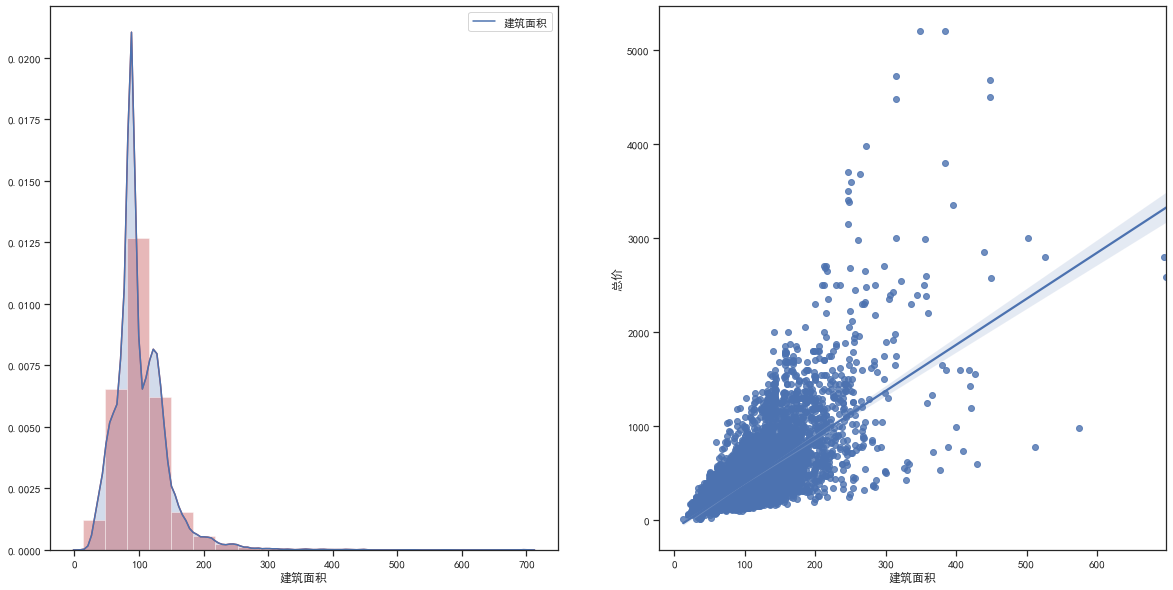

In [37]:
f,[ax1,ax2] = plt.subplots(1,2,figsize = (20,10))

# 建房时间的分布情况
sns.distplot(df['建筑面积'],bins = 20,ax = ax1,color = 'r')
sns.kdeplot(df['建筑面积'],shade = True,ax = ax1)

# 建房时间和出售价格的关系
sns.regplot(x = '建筑面积',y = '总价',data = df,ax =ax2)

- 通过 distplot 和 kdeplot 绘制柱状图观察面积特征的分布情况，属于长尾分布，跟箱型图对比，可以发现很多房源面积很大，超出大部分房源。
- 通过总价和面积的散点图，可以发现，总价和面积基本上呈现线性关系，即面积越大，总价越高，符合常识，图中没有发现异常点。

### 房屋年限分析

In [38]:
df['房屋年限'].value_counts().sort_values()

未满两年     907
满两年     2821
满五年     3119
缺失数据    8345
Name: 房屋年限, dtype: int64

In [39]:
pie1 = pe.Pie('厦门在售二手房房屋年限分布',title_pos='center')

attr = df['房屋年限'].value_counts().sort_values().index.tolist()
v = df['房屋年限'].value_counts().sort_values().values.tolist()

pie1.add('', attr, v, is_label_show=True,is_legend_show=False)
pie1

- 房屋年限情况：房屋年限满2年的房源跟满5年的房源数量比较接近，但是都比未满两年的房源多很多，差距达到3倍。  
- 通过查资料，可以得知，满2年和满5年是指从购买房屋过户缴纳了契税的时间为准，至今的时间间隔已经满2年和满5年；对于卖房者来说，出售不满2年的住房，需要缴纳契税、中介费、个人所得税、5.6%的普通住宅增值税；满2年的住房免征5.6%的增值税；满5年的住房免征5.65%的增值税和个人所得税。因此对于卖房者来说，出售满2年的住房，缴纳的税费更低。这或许可以解释未满2年的房源比满2年和满5年的房源少得多的原因。

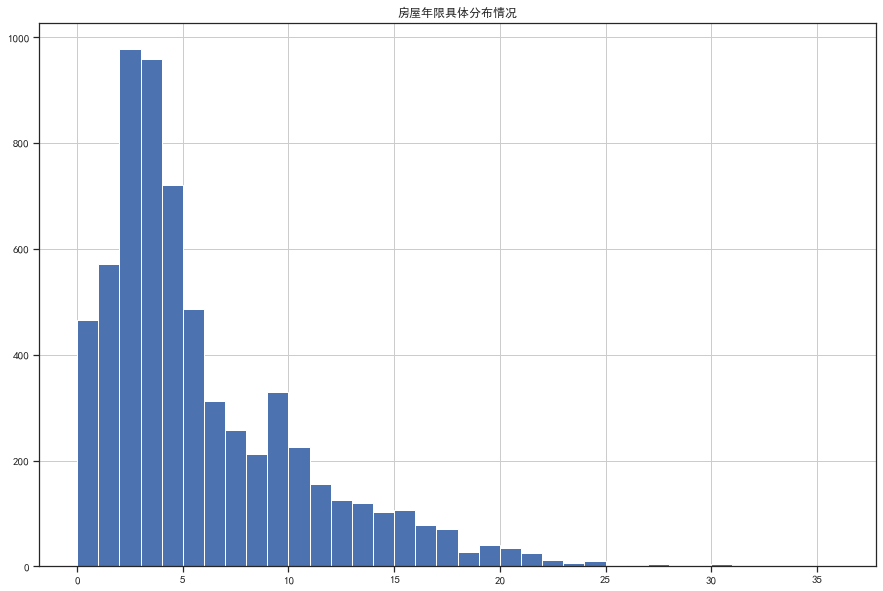

In [78]:
year=df['房屋年限/年'][df['房屋年限/年'].notnull()]
# 指定区间
bins=[x for x in range(37)]
plt.title('房屋年限具体分布情况')
year.hist(bins=bins,figsize=(15,10))

In [41]:
df[df['房屋年限/年']<0].shape

(415, 24)

In [42]:
year.min()

-2.791780821917808

### 房屋户型分析

In [43]:
df['房屋户型'].value_counts()

3室2厅1厨2卫    3294
2室2厅1厨1卫    2814
2室1厅1厨1卫    2210
3室2厅1厨1卫    1828
4室2厅1厨2卫    1369
            ... 
5室1厅0厨2卫       1
6室2厅2厨2卫       1
6室1厅1厨5卫       1
8室4厅1厨4卫       1
7室3厅1厨3卫       1
Name: 房屋户型, Length: 156, dtype: int64

In [44]:
##条形图纵坐标轴无法显示标签
# bar=pe.Bar('房屋户型',title_pos='center',height=900, width=500,)

# attr=df['房屋户型'].value_counts().index.tolist()
# y=df['房屋户型'].value_counts().values.tolist()

# bar.add('',attr,y,is_convert=True,is_legend_show=False)
# bar

Text(0, 0.5, '户型')

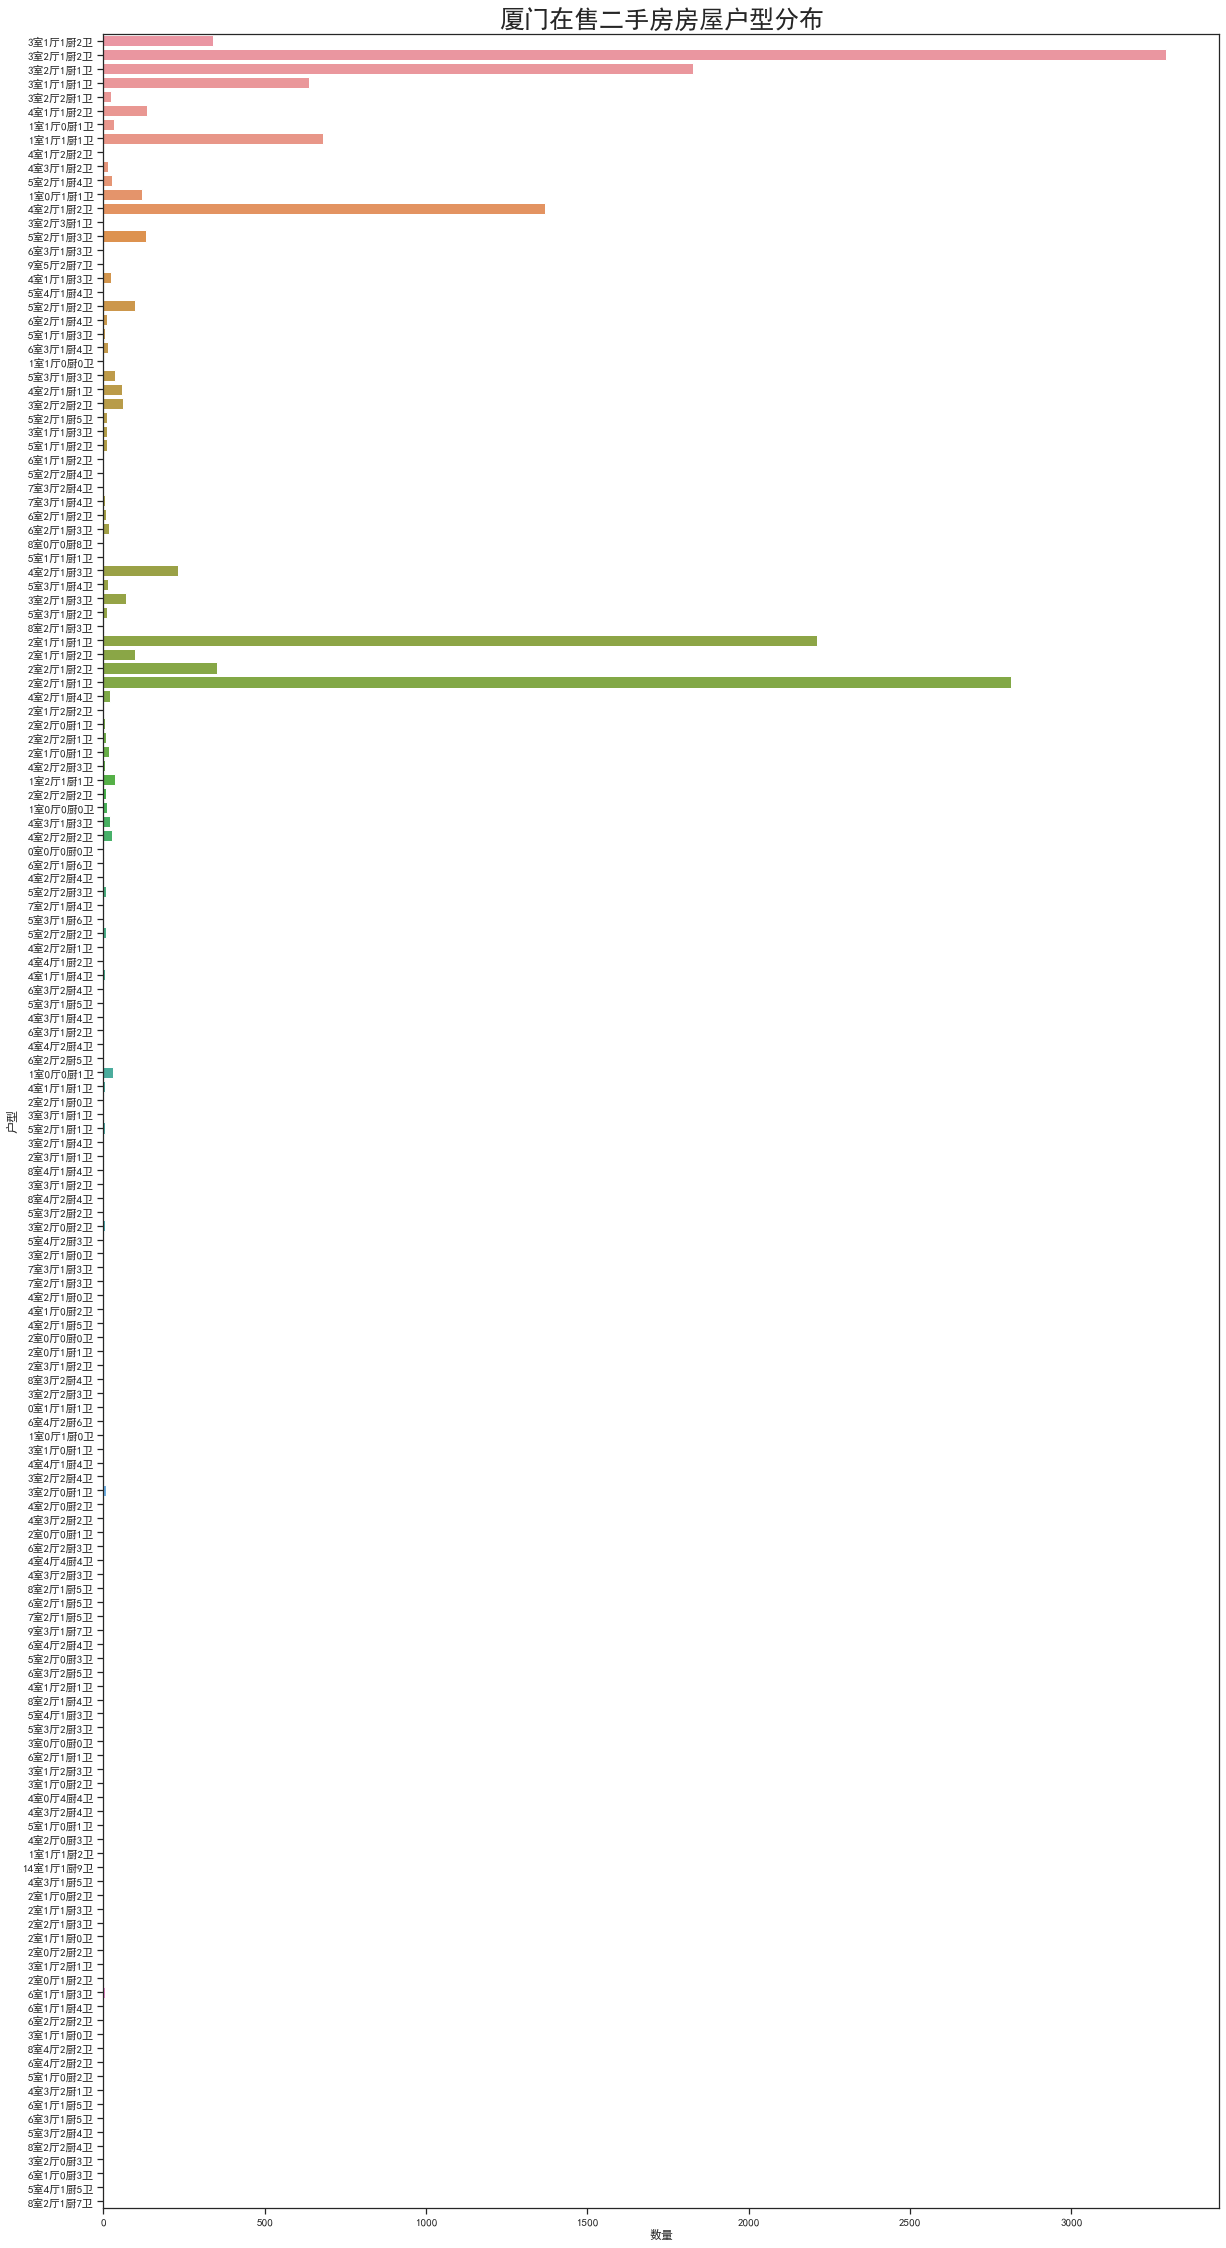

In [45]:
f,ax1 = plt.subplots(figsize = (20,40))
sns.countplot(y = '房屋户型',data = df,ax = ax1)
ax1.set_title('厦门在售二手房房屋户型分布',fontsize=25)
ax1.set_xlabel('数量')
ax1.set_ylabel('户型')

In [46]:
df[df['房屋户型']=='14室1厅1厨9卫']

,总价,单价,小区名称,所在大区,所在详细区域,房屋户型,所在楼层,建筑面积,户型结构,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,房源编码,总楼层,房屋年限/年
10908,2580.0,57487.0,鼓浪屿龙头路,思明,鼓浪屿,14室1厅1厨9卫,低楼层 (共1层),448.8,缺失数据,缺失数据,东南 西北,未知结构,精装,NaN,无电梯,2020-09-07,商品房,NaT,别墅,缺失数据,共有,NaN,1,NaN


- 房屋户型分布：可以看出2室和3室的房源比较多，3室2厅最多，然后是2室2厅，竟然有14室1厅1厨9卫的户型，是位于鼓浪屿的别墅

### 户型结构、装修情况分析

In [47]:
df['户型结构'].value_counts()

平层      13234
复式        864
缺失数据      710
错层        215
跃层        169
Name: 户型结构, dtype: int64

In [48]:
x1 = df.groupby('装修情况')['房源编码'].count().index.tolist()
y1 = df.groupby('装修情况')['房源编码'].count().values.tolist()

x2 = df.groupby('户型结构')['房源编码'].count().index.tolist()
y2 = df.groupby('户型结构')['房源编码'].count().values.tolist()

pie2 = pe.Pie('厦门在售二手房装修情况、户型结构分析', title_pos='center',width=1000)
pie2.add('', x1, y1, center=[30, 55],is_label_show=True)
pie2.add('', x2, y2, center=[70, 55],is_label_show=True,is_legend_show=False)
pie2

- 二手房装修情况：可以看出，在售房源有 56.32% 都是精装修的，超过一半；未装修的毛坯房占比13.51%；  
- 二手房户型结构情况：超过90%的房源是平层的户型结构，错层和跃层的比例都比较低。

### 建筑类型、配备电梯情况分析

In [49]:
x3=df['建筑类型'].value_counts().index.tolist()
y3=df['建筑类型'].value_counts().values.tolist()

x4=df['配备电梯'].value_counts().index.tolist()
y4=df['配备电梯'].value_counts().values.tolist()

pie3 = pe.Pie('厦门在售二手房建筑类型、配备电梯情况分析', title_pos='center',width=1000)
pie3.add('', x3, y3, center=[30, 55],is_label_show=True)
pie3.add('', x4, y4, center=[70, 55],is_label_show=True,is_legend_show=False)
pie3

- 建筑类型情况：超过一半房源的建筑类型是板楼，是塔楼数量的2倍。塔楼和板楼各有优缺点，板楼采光通风好，户型格局不宜改造，价格高；塔楼价格低，结构强度高，但是居住密度高。
- 配备电梯情况：79.17%的房源都配备电梯，是无电梯房源的接近4倍，可以得出结论，房源里以高层住宅（>=6层）为主。

### 单价、区域、配备电梯、装修情况综合分析

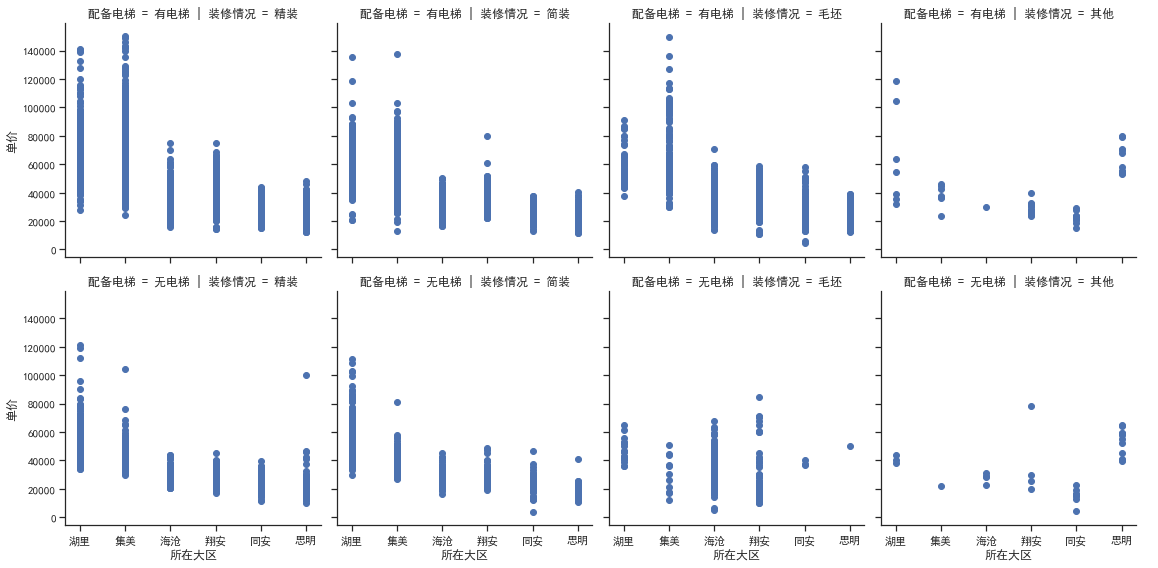

In [50]:
grid = sns.FacetGrid(df,row = '配备电梯',col = '装修情况',palette = 'seismic',size = 4)
grid.map(plt.scatter,'所在大区','单价')
grid.add_legend()

- 综合分析：可以看出，同样的区域，有电梯的房源跟无电梯的房源相比，价格普遍比较高；

## 买房参考

### 湖里区单价3万/平米以内的房源小区名称（小区里面的部分房源）

In [51]:
print(list(set(df[(df['所在大区']=='湖里')&(df['单价']<30000)]['小区名称'].values.tolist())))

['深汇大厦', '芙蓉苑一期', '大唐五缘yoho', '天宇花园北区', '民兴商城', '都市雅苑', '象屿大厦', '怡景花园', '海丝艺术品中心', '宏益华府', '韵园公寓', '和悦里', '榕海花园', '空港·云立方', '嘉福花园']


### 湖里区总价200万以内的房源小区名称（小区里面的部分房源）

In [52]:
print(list(set(df[(df['所在大区']=='湖里')&(df['总价']<200)]['小区名称'].values.tolist())))

['欣华花园', '都市阳光', '怡景花园', '新景园', '信达大厦', '海天路', '徐厝社区三航宿舍（昌宾路8—50号）', '永升新城', '大唐世家一期', '大唐五缘yoho', '建邦大厦', '宏益华府', '古龙公寓', '万华中心', '空港·云立方', '嘉福花园', '铭爵山庄', '恒丰花园2', '加州花园', '象屿大厦', '一元花园二期', '铁路宿舍小区', '鹭槟大厦', '德信庄园', '金彩花苑', '中环花园', '金岭花园', '龙门天下', '太微花园', '都市华庭', '海丝艺术品中心', '都市雅苑', '欣家园']


### 思明区单价3万/平米以内的房源小区名称（小区里面的部分房源）

In [53]:
print(list(set(df[(df['所在大区']=='思明')&(df['单价']<30000)]['小区名称'].values.tolist())))

['鼓浪屿内厝澳路', '华星大厦']


### 思明区总价200万以内的房源小区名称（小区里面的部分房源）

In [54]:
print(list(set(df[(df['所在大区']=='思明')&(df['总价']<200)]['小区名称'].values.tolist())))

['SOHO大厦', '长青路', '一代风华', '金辉园', '浦南花园', '裕发广场', '天宝大厦', '银龙广场二期', '瑞景商业广场公寓楼', '能群大厦', '富山花园紫荆苑', '时尚国际', '美新广场', '音乐家生活广场', '鼓浪屿内厝澳路', '银河大厦', '新嘉园', '美仁前社']


### 异常数据说明

看小区的名称可以发现，部分小区是大厦的名字，房屋用途实际上是属于商业办公类的，但是原始数据录入的时候，房屋用途标注为普通住宅，数据并没有那么完美。

# 二手房价格变化分析

In [55]:
# 成交房源数据，缺少成交时间、小区名称字段
df_deal=pd.read_excel(r"厦门链家网成交二手房爬虫数据_2020-09-26.xlsx")
df_deal.head(3)

,Unnamed: 0,房源链接,总价,单价,挂牌价格,成交周期,房屋户型,所在楼层,建筑面积,户型结构,套内面积,建筑类型,房屋朝向,建成年代,装修情况,建筑结构,供暖方式,梯户比例,配备电梯,链家编号,交易权属,挂牌时间,房屋用途,房屋年限,房权所属
0,0,https://xm.lianjia.com/chengjiao/105104584674....,276万,44302元/平,287挂牌价格（万）,89成交周期（天）,2室1厅1厨1卫,中楼层(共31层),62.3㎡,平层,暂无数据,板塔结合,南,2009,简装,钢混结构,NaN,两梯六户,有,105104584674,商品房,2020-06-13,普通住宅,满五年,非共有
1,1,https://xm.lianjia.com/chengjiao/105104400890....,780万,49415元/平,830挂牌价格（万）,112成交周期（天）,3室2厅1厨2卫,低楼层(共18层),157.85㎡,平层,暂无数据,板楼,南 北,2005,精装,钢混结构,NaN,两梯两户,有,105104400890,商品房,2020-05-21,普通住宅,满五年,非共有
2,2,https://xm.lianjia.com/chengjiao/105102738322....,450万,41857元/平,498挂牌价格（万）,414成交周期（天）,3室2厅1厨1卫,中楼层(共11层),107.51㎡,平层,暂无数据,板楼,南,2005,简装,钢混结构,NaN,一梯两户,有,105102738322,商品房,2019-07-24,普通住宅,满五年,非共有


In [56]:
# 成交房源数据，包含成交时间、小区名称字段
df_url=pd.read_excel(r"厦门链家网成交二手房源链接_2020-09-26.xlsx")
df_url.head(3)

,Unnamed: 0,页面链接,房源链接,小区名称,成交时间
0,0,https://xm.lianjia.com/chengjiao/siming/pg1/,https://xm.lianjia.com/chengjiao/105104776786....,厦禾裕景 车位,2020.09.10
1,1,https://xm.lianjia.com/chengjiao/siming/pg1/,https://xm.lianjia.com/chengjiao/105104748596....,厦禾裕景 2室2厅 93.5平米,2020.09.10
2,2,https://xm.lianjia.com/chengjiao/siming/pg1/,https://xm.lianjia.com/chengjiao/105105262186....,国贸广场 3室2厅 143.53平米,2020.09.10


In [57]:
# 表格匹配，只保留别墅和普通住宅的数据
df_deal = pd.merge(df_deal, df_url, on='房源链接')
df_deal.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)
df_deal = df_deal[[x in ['普通住宅', '别墅'] for x in df_deal['房屋用途']]]
df_deal.head(3)

,房源链接,总价,单价,挂牌价格,成交周期,房屋户型,所在楼层,建筑面积,户型结构,套内面积,建筑类型,房屋朝向,建成年代,装修情况,建筑结构,供暖方式,梯户比例,配备电梯,链家编号,交易权属,挂牌时间,房屋用途,房屋年限,房权所属,页面链接,小区名称,成交时间
0,https://xm.lianjia.com/chengjiao/105104584674....,276万,44302元/平,287挂牌价格（万）,89成交周期（天）,2室1厅1厨1卫,中楼层(共31层),62.3㎡,平层,暂无数据,板塔结合,南,2009,简装,钢混结构,NaN,两梯六户,有,105104584674,商品房,2020-06-13,普通住宅,满五年,非共有,https://xm.lianjia.com/chengjiao/huli/pg1/,湖边花园A区 2室1厅 62.3平米,2020.09.09
1,https://xm.lianjia.com/chengjiao/105104400890....,780万,49415元/平,830挂牌价格（万）,112成交周期（天）,3室2厅1厨2卫,低楼层(共18层),157.85㎡,平层,暂无数据,板楼,南 北,2005,精装,钢混结构,NaN,两梯两户,有,105104400890,商品房,2020-05-21,普通住宅,满五年,非共有,https://xm.lianjia.com/chengjiao/huli/pg1/,联发新天地 3室2厅 157.85平米,2020.09.09
2,https://xm.lianjia.com/chengjiao/105102738322....,450万,41857元/平,498挂牌价格（万）,414成交周期（天）,3室2厅1厨1卫,中楼层(共11层),107.51㎡,平层,暂无数据,板楼,南,2005,简装,钢混结构,NaN,一梯两户,有,105102738322,商品房,2019-07-24,普通住宅,满五年,非共有,https://xm.lianjia.com/chengjiao/huli/pg1/,阳光美地 3室2厅 107.51平米,2020.09.09


In [58]:
len(df_deal)

9389

In [59]:
df_deal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9389 entries, 0 to 10386
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   房源链接    9389 non-null   object 
 1   总价      9389 non-null   object 
 2   单价      9389 non-null   object 
 3   挂牌价格    9389 non-null   object 
 4   成交周期    9389 non-null   object 
 5   房屋户型    9389 non-null   object 
 6   所在楼层    9389 non-null   object 
 7   建筑面积    9389 non-null   object 
 8   户型结构    9389 non-null   object 
 9   套内面积    9389 non-null   object 
 10  建筑类型    9389 non-null   object 
 11  房屋朝向    9389 non-null   object 
 12  建成年代    9389 non-null   object 
 13  装修情况    9389 non-null   object 
 14  建筑结构    9389 non-null   object 
 15  供暖方式    0 non-null      float64
 16  梯户比例    9389 non-null   object 
 17  配备电梯    9389 non-null   object 
 18  链家编号    9389 non-null   object 
 19  交易权属    9389 non-null   object 
 20  挂牌时间    9389 non-null   object 
 21  房屋用途    9389 non-null   object 
 22 

## 数据清洗（成交房源）

In [60]:
print(len(df_deal[df_deal.duplicated()])) # 查看重复值数量
# df_deal.drop_duplicates(inplace=True)  # 删除重复值

0


### 区域字段清洗

In [61]:
# 数据没有区域字段，区域字段从页面链接里获取
df_deal['所在大区'] = df_deal['页面链接'].map(lambda x: x.split(r'/')[4])
df_deal['所在大区']

0           huli
1           huli
2           huli
4           huli
5           huli
          ...   
10382    haicang
10383    haicang
10384    haicang
10385    haicang
10386    xiangan
Name: 所在大区, Length: 9389, dtype: object

In [62]:
# 区域映射
df_deal['所在大区'] = df_deal['所在大区'].map(
    {'siming': '思明', 'huli': '湖里', 'jimei': '集美', 'haicang': '海沧', 'xiangan': '翔安', 'tongan': '同安'})
df_deal['所在大区']

0        湖里
1        湖里
2        湖里
4        湖里
5        湖里
         ..
10382    海沧
10383    海沧
10384    海沧
10385    海沧
10386    翔安
Name: 所在大区, Length: 9389, dtype: object

### 小区名称字段清洗

In [63]:
df_deal['小区名称']=df_deal['小区名称'].map(lambda x:x.split(' ')[0])
df_deal['小区名称']

0          湖边花园A区
1           联发新天地
2            阳光美地
4         第二城幸福生活
5        大唐世家三,五期
           ...   
10382     绿苑新城二组团
10383      旭日海湾三期
10384       天湖城天湖
10385        天御小区
10386       联合博学园
Name: 小区名称, Length: 9389, dtype: object

### 成交时间字段清洗

In [64]:
df_deal['成交时间'] = pd.to_datetime(df_deal['成交时间'])
df_deal['成交时间']

0       2020-09-09
1       2020-09-09
2       2020-09-09
4       2020-09-09
5       2020-09-09
           ...    
10382   2020-09-10
10383   2020-09-10
10384   2020-09-10
10385   2016-04-05
10386   2020-09-10
Name: 成交时间, Length: 9389, dtype: datetime64[ns]

### 成交周期字段清洗

In [65]:
# 正则表达式，查找成交周期列的数字
find = re.compile('\d{1,4}')

df_deal['成交周期/天'] = df_deal['成交周期'].map(
    lambda x: find.findall(x)[0] if len(find.findall(x)) > 0 else np.nan)
df_deal['成交周期/天'] = df_deal['成交周期/天'].astype(np.float64)

# 空值填充平均值
df_deal['成交周期/天'].fillna(df_deal['成交周期/天'].mean())
df_deal['成交周期/天']

0         89.0
1        112.0
2        414.0
4        506.0
5         42.0
         ...  
10382     29.0
10383     17.0
10384    139.0
10385      1.0
10386      6.0
Name: 成交周期/天, Length: 9389, dtype: float64

### 单价字段清洗

In [66]:
df_deal['单价']=df_deal['单价'].str.replace('元/平','')  # 去掉单位
df_deal['单价']=df_deal['单价'].astype(np.float64)  # 转化为浮点型

## 成交房源数据分析及可视化

### 成交数量分析

In [67]:
df_deal_time=df_deal[['链家编号','成交时间']]
df_deal_time.set_index('成交时间',inplace=True)
# 以月为单位重采样
df_deal_time.resample('M').count().head()

,链家编号
成交时间,
2015-05-31,1
2015-06-30,0
2015-07-31,0
2015-08-31,0
2015-09-30,9


In [68]:
# 绘制折线图
line2 = pe.Line('二手房成交数量时间分布', title_pos='center', width=1200, height=550)

# 以月为单位重采样
attr_line2 = df_deal_time.resample(
    'M').count().index.strftime('%Y-%m').tolist()
v_line2 = df_deal_time.resample('M').count()['链家编号'].values.tolist()

# 绘制总成交数量折线图
# is_label_show=True,显示数据标签;is_datazoom_show=True控制条，xaxis_interval=0,所有横坐标标签都显示,xaxis_rotate=60,标签旋转60度
line2.add('总成交数量', attr_line2, v_line2, is_label_show=True, is_datazoom_show=True, xaxis_interval=0,
          xaxis_rotate=60, yaxis_name='数量', yaxis_name_gap=20, yaxis_name_pos='end', legend_top='6%', is_smooth=True)

# 分区域绘制折线图
for i in x_axis:
    df_deal_pos = df_deal[df_deal['所在大区'] == i][['链家编号', '成交时间']]
    df_deal_pos.set_index('成交时间', inplace=True)
    attr_linei = df_deal_pos.resample(
        'M').count().index.strftime('%Y-%m').tolist()
    v_linei = df_deal_pos.resample('M').count()['链家编号'].values.tolist()
    line2.add(i, attr_linei, ["%.0f" % x for x in v_linei], legend_top='6%', is_label_show=False, is_datazoom_show=True,
              xaxis_interval=0, xaxis_rotate=60, yaxis_name='元/平米', yaxis_name_gap=20, yaxis_name_pos='end',
              is_smooth=True, is_stack=False)
line2

- 二手房成交数量：可以看出成交数量的峰值在不断提高，二手房交易市场活跃，因为2020年疫情原因，2月份二手房成交量跟1月份相比暴跌 92.5%，厦门所有区域二手房成交数量都有明显的下跌，随着3月份经济活动逐渐恢复，二手房成交量开始回升，并在5月份超过2019年12月份的最高值，5到8月份，月成交数量稳定在600套以上，9月份开始回落，由于成交二手房源数据采集时间是2020-9-26，并没有完全统计9月份的成交数量，但还是可以看到9月份二手房成交数量有明显的下降。
- 厦门各个区域里，思明区的二手房源交易最为活跃，紧接着是集美区，湖里区和海沧区，成交数量比较接近。

### 成交均价分析

In [69]:
df_deal_unit=df_deal[['单价','成交时间']]
df_deal_unit.set_index('成交时间',inplace=True)
# 以月为单位重采样
df_deal_unit.resample('M').mean().head()

,单价
成交时间,
2015-05-31,30572.000000
2015-06-30,NaN
2015-07-31,NaN
2015-08-31,NaN
2015-09-30,24012.111111


In [70]:
# 绘制折线图
line3 = pe.Line('二手房成交均价时间分布', title_pos='center', width=1200, height=550)

# 以月为单位重采样
attr_line3 = df_deal_unit.resample('M').mean().index.strftime('%Y-%m').tolist()
v_line3 = df_deal_unit.resample('M').mean()['单价'].values.tolist()

# 绘制均价折线图
# is_label_show=True,显示数据标签;is_datazoom_show=True控制条，xaxis_interval=0,所有横坐标标签都显示,xaxis_rotate=60,标签旋转60度
line3.add('成交均价', attr_line3, ["%.0f" % x for x in v_line3], is_label_show=False, is_datazoom_show=True,
          xaxis_interval=0, xaxis_rotate=60, yaxis_name='元/平米', yaxis_name_gap=20, yaxis_name_pos='end', legend_top='6%', is_smooth=True,)

# 分区域绘制折线图
for i in x_axis:
    df_deal_pos = df_deal[df_deal['所在大区'] == i][['单价', '成交时间']]
    df_deal_pos.set_index('成交时间', inplace=True)
    attr_linei = df_deal_pos.resample(
        'M').mean().index.strftime('%Y-%m').tolist()
    v_linei = df_deal_pos.resample('M').mean()['单价'].values.tolist()
    line3.add(i, attr_linei, ["%.0f" % x for x in v_linei], legend_top='6%', is_label_show=False, is_datazoom_show=True,
              xaxis_interval=0, xaxis_rotate=60, yaxis_name='元/平米', yaxis_name_gap=20, yaxis_name_pos='end', is_smooth=True,)
line3

- 二手房成交均价：2016年6月份到2020年9月份，二手房成交均价在不断上升，2017年6月和7月，均价3万/平米左右，2020年的成交均价基本上都在4万/平米以上了，虽然均价在2018年年初有回调，但是到了2018年年底，又开始稳步上升了，2018年均价回调的原因应该是中美爆发贸易摩擦带来的局势不稳定。
- 思明和湖里两个区域，成交均价始终在平均值以上，思明区成交均价稳步在5万/平米以上，湖里区成交均价在4到5万/平米之间，翔安和同安的成交均价，始终在3万/平米以内。

In [71]:
# 用seaborn绘制中和图表
# df_deal['计数']=1
# sns.FacetGrid(data=df_deal, size=8, aspect=1.5).map(sns.pointplot,
#                                                      '成交时间', '计数', '所在大区', palette='deep', ci=None).add_legend()

# plt.show()

### 成交周期分析

In [72]:
df_deal_period=df_deal[['成交周期/天','成交时间']]
df_deal_period.set_index('成交时间',inplace=True)
# # 以月为单位重采样
df_deal_period.resample('M').mean().head()

,成交周期/天
成交时间,
2015-05-31,NaN
2015-06-30,NaN
2015-07-31,NaN
2015-08-31,NaN
2015-09-30,31.428571


In [73]:
# 绘制折线图
line4 = pe.Line('二手房成交周期时间分布', title_pos='center', width=1200, height=450)

# 以月为单位重采样
attr_line4 = df_deal_period.resample(
    'M').mean().index.strftime('%Y-%m').tolist()
v_line4 = df_deal_period.resample('M').mean()['成交周期/天'].values.tolist()

# is_label_show=True,显示数据标签;is_datazoom_show=True控制条，xaxis_interval=0,所有横坐标标签都显示,xaxis_rotate=60,标签旋转60度
line4.add('成交周期', attr_line4, ["%.0f" % x for x in v_line4], is_label_show=True, is_datazoom_show=True, xaxis_interval=0,
          xaxis_rotate=60, yaxis_name='成交周期/天', yaxis_name_gap=20, yaxis_name_pos='end', legend_top='7%', is_smooth=True)
line4

- 二手房成交周期：2015年到2020年二手房成交周期越来越长，从2015年的1个月左右，到2020年的5个月左右。

### 二手房挂牌总数量分析（包含在售房源和成交房源）

In [74]:
# 绘制叠加折线图
line5 = pe.Line('二手房挂牌总数量时间分布叠加图', title_pos='center',
                width=1200, height=550)

attr_line2 = df_deal_time.resample(
    'M').count().index.strftime('%Y-%m').tolist()
v_line2 = df_deal_time.resample('M').count()['链家编号'].values.tolist()

# is_label_show=True,显示数据标签;is_datazoom_show=True控制条，xaxis_interval=0,所有横坐标标签都显示,xaxis_rotate=60,标签旋转60度
line5.add('在售数量', attr_line, v_line, is_label_show=False, is_datazoom_show=True, xaxis_interval=0, xaxis_rotate=60,
          yaxis_name='数量', yaxis_name_gap=20, yaxis_name_pos='end', is_smooth=True, legend_top='6%', is_stack=True, area_opacity=0.4)
line5.add('成交数量', attr_line2, v_line2, is_label_show=False, is_datazoom_show=True, xaxis_interval=0, xaxis_rotate=60,
          yaxis_name='数量', yaxis_name_gap=20, yaxis_name_pos='end', legend_top='6%', is_smooth=True, is_stack=True, is_fill=True, area_color="#000", area_opacity=0.3)

line5

- 二手房挂牌总数量：2019年和2020年链家网房源的挂牌数量和成交数量，比2018年以前多得多，也可以看到，2018年以前挂牌的房源基本上都成交了，跟我们项目开始分析在售房源数量的时候预测的一致。

### 保存可交互式图表

In [75]:
# 将项目里的多个图表显示在一个网页内
page = pe.Page()
page.add(line)
page.add(bar1)
page.add(overlap1)
page.add(overlap2)
page.add(overlap3)
page.add(overlap4)
page.add(pie1)
page.add(pie2)
page.add(pie3)
page.add(line2)
page.add(line3)
page.add(line4)
page.add(line5)
page.render('厦门二手房项目图表.html') # 保存为本地 html 文件

# 总结
- 厦门在售二手房源价格总体情况：根据现有的15192套在售二手房源，均价是39613.9元/平米，单价3万/平米以内的房源只有1/3；平均总价405万，总价在300万以内的房源占比只有41.9%，总价在500万以内的房源占比79.7%，从均价和总价来看，可以说厦门房价非常高。  
- 综合在售房源和成交房源的挂牌数量、成交数量、成交均价、成交总价、成交周期和时间的关系，可以看出，现阶段虽然厦门二手房价格非常高，成交周期比较漫长，但是成交量非常活跃，卖房者数量越来越多，买房者数量并没有因为高房价而减少。  
- 分析在售房源数据的最后，预算相对没那么多的情况下，给出了一些厦门岛内可选的房源，供参考选择。同样的预算，在岛外选择相对会比较多。

# 本项目存在的不足

### 数据样本不够大。
数据来源于链家网采集，不管是在售房源还是成交房源，链家网上都只能采集前100个页面的数据，即使分区域（思明、湖里、集美、海沧、翔安、同安）多次采集，我们能采集到的数据还是有限的，无法采集到链家网上所有的房源数据。好在链家网上我们采集到了55%的在售二手房数据，90%的成交二手房数据，所得到的结论，也具有一定的代表性，还是能够在一定程度上反映现阶段厦门的二手房市场情况。

# 项目之后

一个城市房价的影响因素有哪些，接下来我们将用 python 数据挖掘算法构建一个简易的模型来预测房价，给模型输入一些特征，比如：区域、面积、房屋户型、户型结构、、是否配备电梯、装修情况等，根据这些特征，模型可以预测出这套房源的总价。这是这个项目后面要做的一个补充。